# Initializing: run this notebook in colab!

Also upload the Offside_Images folder and set its path to the variable "img_folder".

In [ ]:
!source .venv/bin/activate; python -m pip install pyyaml==6.0
!source .venv/bin/activate; python -m pip install Pillow
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!source .venv/bin/activate; python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

In [24]:
# import some common libraries
import numpy as np
import json, cv2, re
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from collections import Counter

# import clustering models
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:
#Importing images from dataset
from google.colab import drive
drive.mount('/content/drive')

# Change this variable to your dataset directory
img_folder = "/content/drive/MyDrive/Exame_VAR/dataset/Offside_Images"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


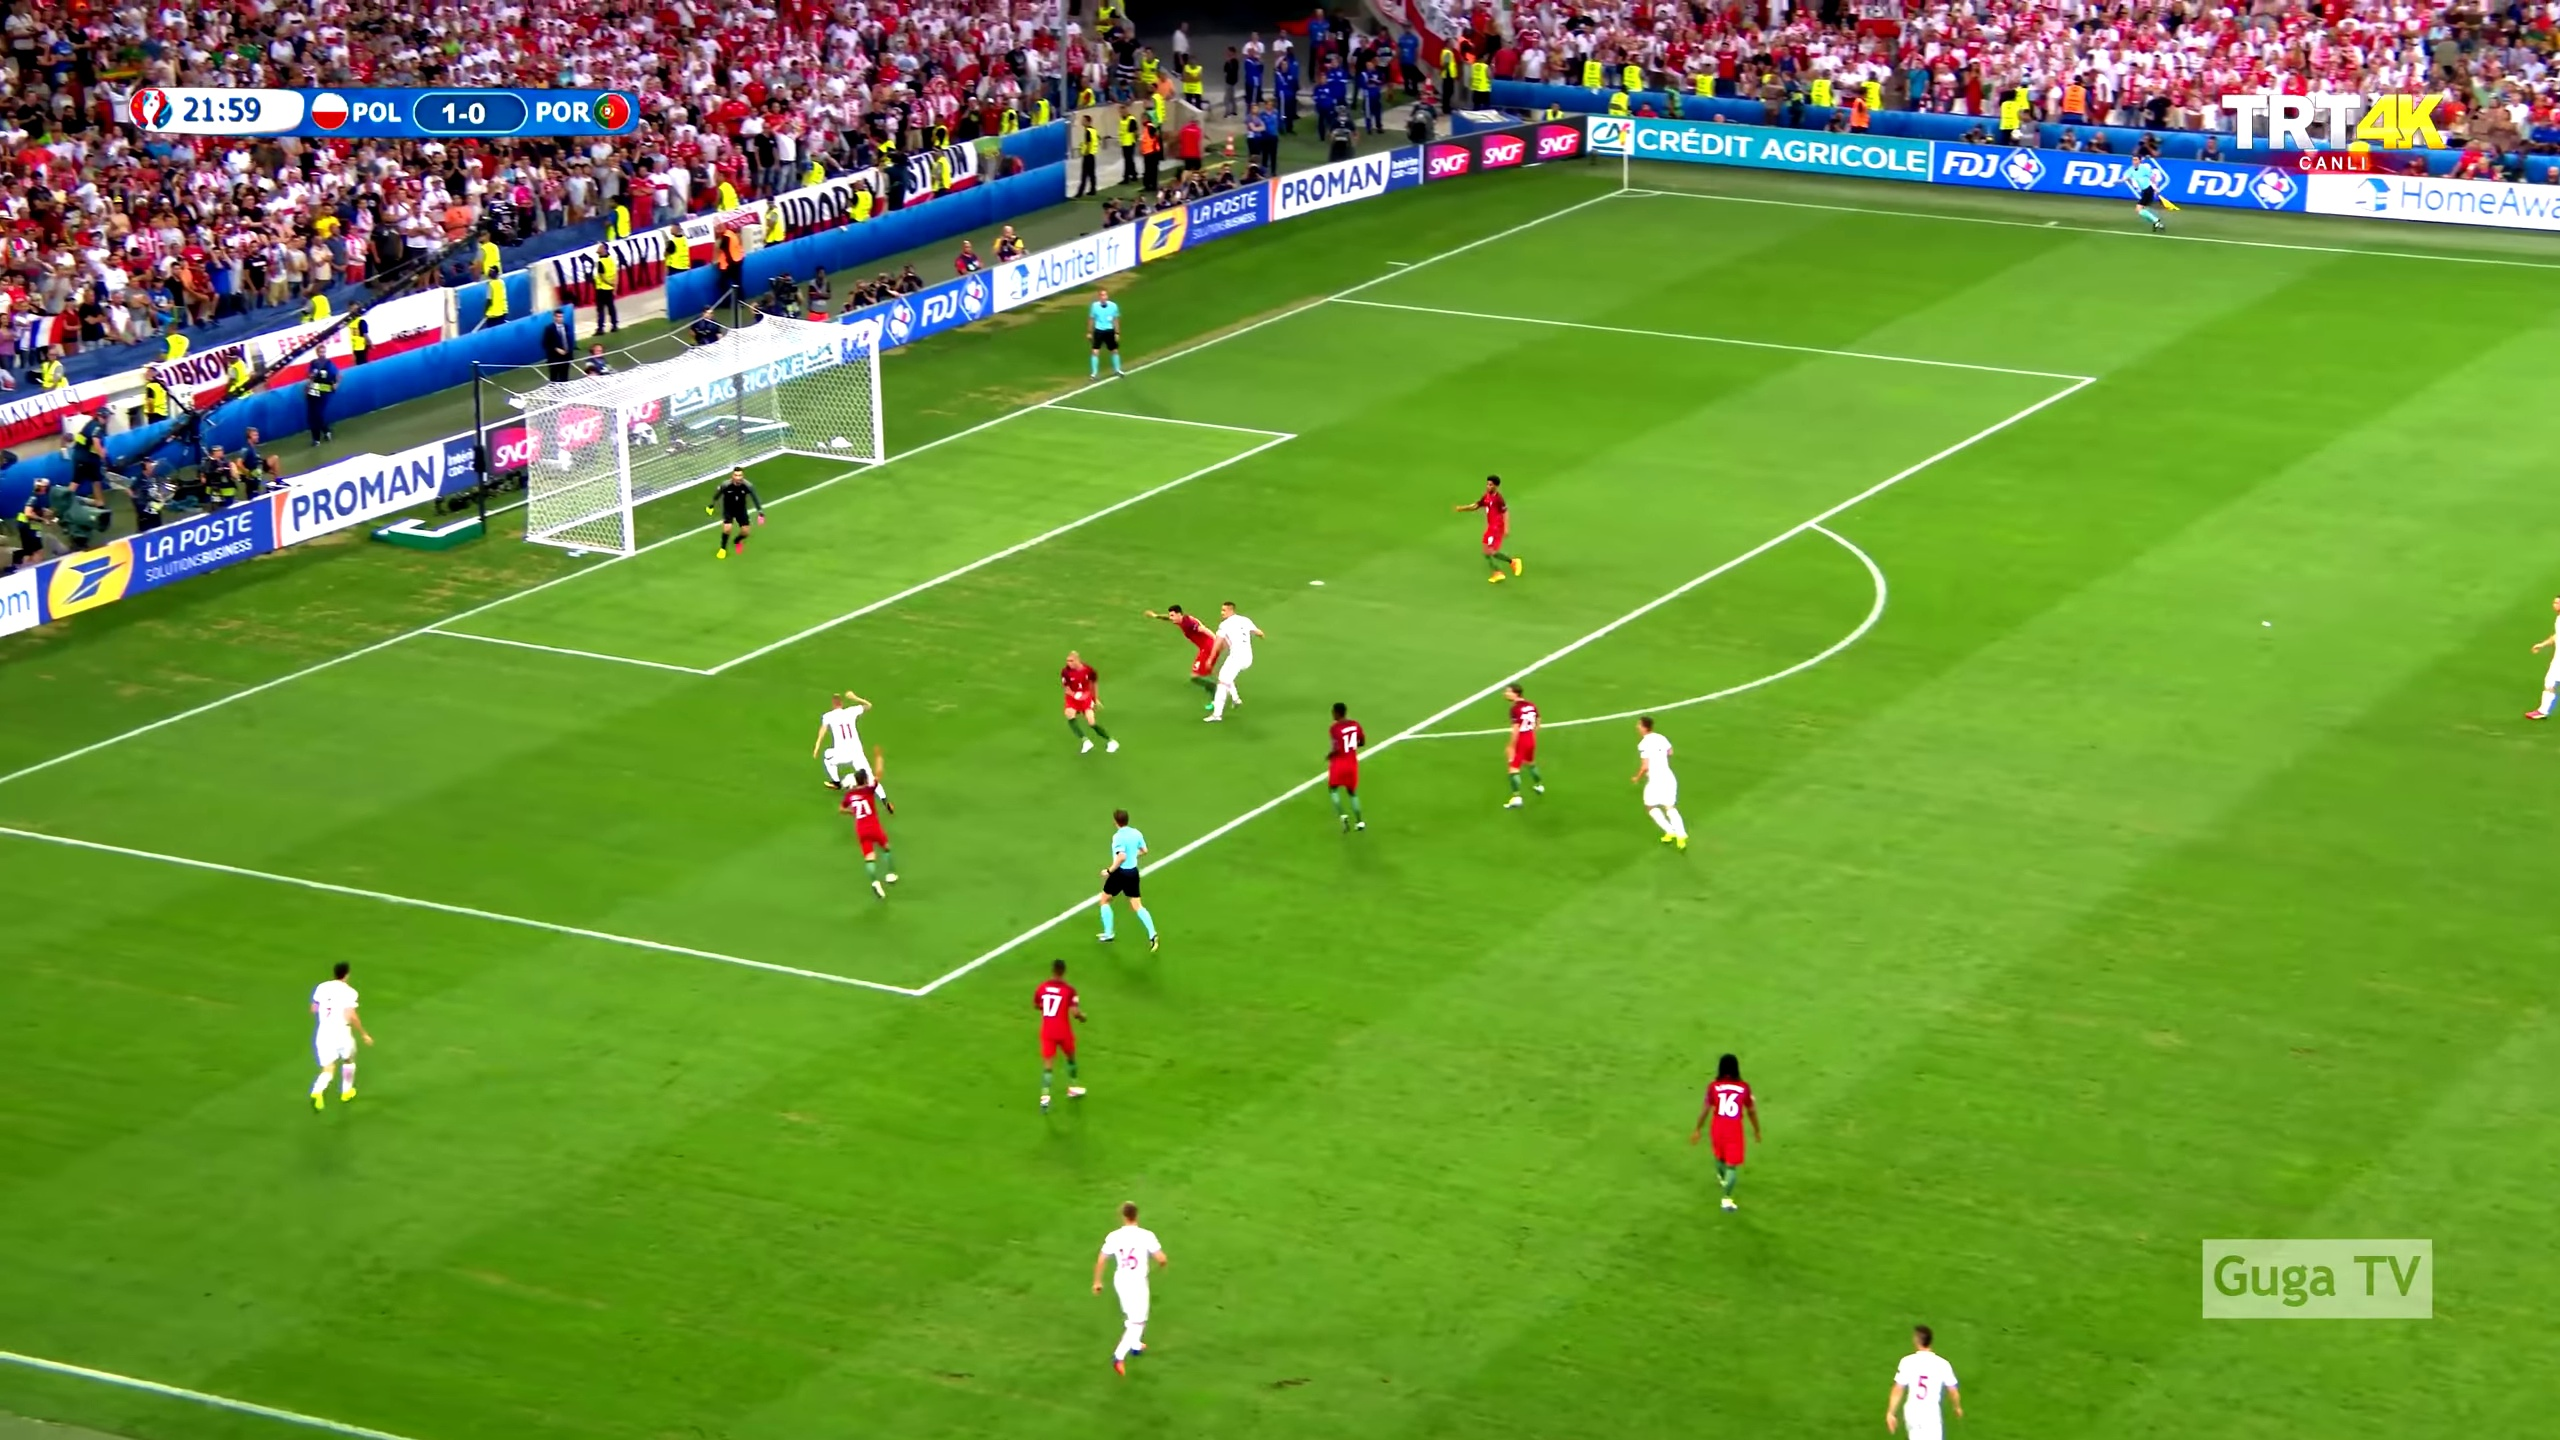

In [4]:
# Example image
my_image = cv2.imread(f"{img_folder}/4.jpg")
cv2_imshow(my_image)

In [ ]:
# Using panoptic segmentation to get field area
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
panoptic_predictor = DefaultPredictor(cfg)

# keypoint detection model
cfg_keypoint = get_cfg()   # get a fresh new config
cfg_keypoint.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg_keypoint.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg_keypoint.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
keypoint_predictor = DefaultPredictor(cfg_keypoint)


In [6]:
def isolate_field(image, cfg, panoptic_predictor):
    panoptic_seg, segments_info = panoptic_predictor(image)["panoptic_seg"]
    v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
    max_person_area = 0

    for info in segments_info:
        if(info['category_id'] == 18): # playing field
            field_id = info['id']

        if(info['category_id'] == 0):  # person
            max_person_area = max(max_person_area, info['area'])

    dilate_size = round(np.sqrt(max_person_area)*1.5)
    erode_size = round(np.sqrt(max_person_area)/2)

    dilate_box = np.ones((dilate_size, dilate_size))
    erode_box = np.ones((erode_size, erode_size))


    field_area = np.where(np.array(panoptic_seg.cpu()) == field_id, 255, 0)
    field_area = np.array(field_area, np.uint8)
    field_area = cv2.erode(field_area, erode_box)
    field_area = cv2.dilate(field_area, dilate_box)

    edited_image = image.copy()
    edited_image[field_area == 0] = 0

    return edited_image


In [7]:
def get_people_keypoints(image, cfg, panoptic_predictor, keypoint_predictor):
    outputs = keypoint_predictor(isolate_field(image, cfg, panoptic_predictor))

    people = []

    # Iterate through keypoints and add them to list
    keypoints = outputs["instances"].pred_keypoints.cpu()
    for i, instance_keypoints in enumerate(keypoints):
        person_info = dict()
        person_info['keypoints'] = np.concatenate((instance_keypoints[0:1,:2], instance_keypoints[5:6,:2],
                                            instance_keypoints[11:12,:2], instance_keypoints[13:14,:2],
                                            instance_keypoints[15:,:2], instance_keypoints[14:15,:2],
                                            instance_keypoints[12:13,:2],instance_keypoints[6:7,:2]), axis=0).tolist()
        person_info['player_id'] = i
        people.append(person_info)

    return people

# Reading keypoints from dataset

Original dataset is final_data.json. The chunk below converts it to the format utilized by this notebook. Also, it removes entries with error from the original json file.

In [ ]:
'''
def extract_number_from_filename(filename):
   match = re.search(r'\d+', filename)
   if match:
       return int(match.group(0))
   else:
       return None

def dataset_players_infos(img_folder):
    json_file = os.path.join(img_folder, "final_data.json")
    with open(json_file) as f:
        img_data_list = json.load(f)

    dataset_dicts = []
    for img_data in img_data_list:
        data_with_error = False
        if type(img_data["Pose"]) != str:
            record = {}
            filename = os.path.join(img_folder, img_data["Image_ID"])
            height, width = cv2.imread(filename).shape[:2]

            record["file_name"] = filename
            record["image_id"] = extract_number_from_filename(filename)
            record["height"] = height
            record["width"] = width

            players = []
            id = 0
            for team in (img_data["Pose"]).keys():
                for player in img_data["Pose"][team]:
                    player_info = dict()
                    keypoint_list = []
                    keypoints = player["geometry"]

                    if len(keypoints) != 9:
                        data_with_error = True
                    for keypoint in keypoints:
                        x = float(keypoint["x"])
                        y = float(keypoint["y"])
                        keypoint_list.append([x,y])

                    player_info["keypoints"] = keypoint_list
                    player_info["player_id"] = id
                    player_info["team"] = team
                    players.append(player_info)

                    id += 1

            record["players"] = players

        if not data_with_error:
            dataset_dicts.append(record)

    return dataset_dicts

dataset_players = dataset_players_infos(img_folder)

with open('/content/converted_dataset.json', 'w') as f:
   json.dump(dataset_players, f)
'''

You can use the already converted file to get the results quicker.

In [8]:
with open(f'{img_folder}/converted_dataset.json', 'r') as f:
    dataset_players = json.load(f)

# Getting keypoints with detectron

In [ ]:
'''
detectron_players = []

for image in dataset_players:
    image_info = dict()
    file_name = image['file_name']

    image_info['file_name'] = file_name
    image_info['image_id'] = image['image_id']
    image_info['height'] = image['height']
    image_info['width'] = image['width']
    image_info['players'] = get_people_keypoints(cv2.imread(file_name), cfg, panoptic_predictor, keypoint_predictor)
    detectron_players.append(image_info)

with open('/content/detectron_dataset.json', 'w') as f:
   json.dump(detectron_players, f)
'''

You can get the results quicker reading the already built json file.

In [9]:
with open(f'{img_folder}/detectron_dataset.json', 'r') as f:
    detectron_players = json.load(f)

# Associating original data with detectron detected players



In [11]:
# Array format will allow use numpy to associate the players from both datasets

def keypoint_list_to_array(dataset_dict):
    dataset_copy = dataset_dict.copy()
    for image in dataset_copy:
        keypoints_arrays = [np.array(player['keypoints'])[..., None] for player in image['players']]
        image['keypoint_array'] = np.concatenate(keypoints_arrays, -1)
    return dataset_copy

From now and on, "dataset" refers to the original dataset and "detectron" to the data obtained with Detectron2

In [12]:
dataset_images = keypoint_list_to_array(dataset_players)
detectron_images = keypoint_list_to_array(detectron_players)

We associate the player from detectron A to the player from dataset B if:

1) Among all players from detectron data, A has the lowest keypoint MSE error with B

2) This MSE error is less than 1e3

In [14]:
'''
for i, image in enumerate(dataset_images):
    dataset_array = image['keypoint_array'][:, :, None, :]
    detectron_array = detectron_images[i]['keypoint_array'][..., None]

    mse_array = np.power(dataset_array - detectron_array, 2)
'''

def associate_players(dataset_array, detectron_array, max_mse = 1e3):
    mse_array = np.mean(
        np.power(dataset_array[:, :, None, :] - detectron_array[..., None], 2),
        axis = (0,1)
    )

    total_players = mse_array.shape[1]

    associated_id = mse_array.argmin(axis = 1)
    min_mse = np.min(mse_array, axis = 1)

    associations = dict()
    min_mse_for_player = [max_mse] * total_players
    for id_detectron, id_dataset in enumerate(associated_id):
        if min_mse_for_player[associated_id[id_detectron]] > min_mse[id_detectron]:
            associations[id_dataset] = id_detectron
            min_mse_for_player[id_dataset] = min_mse[id_detectron]

    detected_players = len(associations)

    return associations, min_mse, total_players, detected_players

This function below returns a list of dictionary. Each dictionary is associated to an image in the dataset and sets the relation between the dataset player ID (key) and the detectron player ID (value).

The ID is the index of the player in image['players'] list

In [16]:
def get_associated_players(dataset_images, detectron_images):
    associations_list = []
    for i, dataset_image in enumerate(dataset_images):
        association_dict = dict()
        association_dict['image_id'] = dataset_image['image_id']
        dataset_array = dataset_image['keypoint_array']
        detectron_array = detectron_images[i]['keypoint_array']
        associations, mse, total_players, detected_players = associate_players(dataset_array, detectron_array)
        association_dict['associations'] = associations
        association_dict['mse'] = mse
        association_dict['total_players'] = total_players
        association_dict['detected_players'] = detected_players
        associations_list.append(association_dict)
    return associations_list



In [18]:
associations_list = get_associated_players(dataset_images, detectron_images)

In [19]:
total = sum([image['total_players'] for image in associations_list])
detected = sum([image['detected_players'] for image in associations_list])

detected/total

0.9500544860152561

Above we can see that Detectron2 could identify <b>95%</b> of the players from the dataset

# Segregating GK, Referees and unidentified players

In [20]:
def get_mean_color(image, points):
    '''
    returns the mean color in the polygonal region delimited by the points
    '''
    mask = np.zeros(image.shape[:2], dtype="uint8")
    cv2.fillPoly(mask, np.int32([points]), 255)
    mean_color = cv2.mean(image, mask=mask)[:-1]
    return mean_color

def get_color_list(image, points):
    '''
    makes (10,10) average pools on the polygonal region delimited by each player and returns the list of obtained colors
    '''
    pool_size = 10
    result = []

    mask = np.zeros(image.shape[:2], dtype="uint8")
    cv2.fillPoly(mask, np.int32([points]), 255)

    # Iterate over the image and mask using the pool size
    for y in range(0, image.shape[0], pool_size):
        for x in range(0, image.shape[1], pool_size):
            # Check if the current region in the mask is non-zero (masked)
            masked_pixels = np.sum(mask[y:y + pool_size, x:x + pool_size])
            if masked_pixels > 0:
                # Calculate the mean color in the region
                sum_color = np.sum(image[y:y + pool_size, x:x + pool_size], axis=(0, 1))
                mean_color = sum_color/masked_pixels
                result.append(mean_color)

    return result

In [26]:
def color_amplify(color_array):
    '''
    returns a modified array of BGR colors.
    The modification involves amplifying the difference between the bigger and the lower BGR component.
    This way, visually similar colors will have small euclidean distance.
    '''

    sum_colors = np.sum(color_array, axis = 1)[:, None]
    normalized = color_array/sum_colors
    transformer = np.exp(2*normalized) - 1
    transformed = normalized*transformer
    normalized_transformed = transformed/np.sum(transformed, axis = 1)[:, None]

    return np.clip(normalized_transformed * sum_colors, 0, 255)

def cluster_teams(image_info, eps = 55):
    '''
    Uses the DBSCAN clustering model to segregate field players (team1 and 2) and
    other persons (GK, referees and possibly unidentified people)
    '''

    n_samples = len(image_info['players'])
    image = cv2.imread(image_info['file_name'])
    player_colors = []
    average_colors = []
    for player in image_info['players']:
        keypoints = player['keypoints']
        points = np.array([keypoints[1], keypoints[2], keypoints[7], keypoints[8]])
        player_colors += get_color_list(image, points)
        average_colors.append(get_mean_color(image, points))

    #amplified = color_amplify(np.array(player_colors))
    db = DBSCAN(eps=eps, min_samples=1)
    db.fit(color_amplify(np.array(player_colors + average_colors)))
    return list(db.labels_[-len(average_colors):])

# Analysing the results with DBSCAN model

Now, we are going to compare the GK classification using the DBSCAN model with the GK classification from dataset. We are going to analyse two measurements:

1) Percentage of times that the goalkeaper is correctly identified as GK by DBSCAN;

2) Percentage of times that a player from Team1 or Team2 is incorrectly classified as GK by DBSCAN.

In [37]:
def get_teams(labels):
    counter = Counter(labels)
    team1 = max(counter, key=counter.get)
    counter.pop(team1)
    team2 = max(counter, key=counter.get)

    return team1, team2

def verify_gk(labels, player_category):
    t1, t2 = get_teams(labels)
    return (player_category != t1 and player_category != t2)

We are using eps = 55 as default.

In [41]:
total_gk = 0
correct_gk = 0

for image_idx, (dataset_image, detectron_image) in enumerate(zip(dataset_images, detectron_images)):
    associations = associations_list[image_idx]['associations']
    labels = cluster_teams(detectron_image)

    for i, dataset_player in enumerate(dataset_image['players']):
        if dataset_player['team'] == 'GK' and i in associations.keys():
            total_gk += 1
            if verify_gk(labels, labels[associations[i]]):
                correct_gk += 1

In [42]:
correct_gk/total_gk

0.9704142011834319

In [ ]:
field_players = 0
wrong_gk = 0

for image_idx, (dataset_image, detectron_image) in enumerate(zip(dataset_images, detectron_images)):
    associations = associations_list[image_idx]['associations']
    labels = cluster_teams(detectron_image)
    team1, team2 = get_teams(labels)
    for i, dataset_player in enumerate(dataset_image['players']):
        if (dataset_player['team'] == 'Team1' or dataset_player['team'] == 'Team2') and i in associations.keys():
            field_players += 1
            if labels[associations[i]] != team1 and labels[associations[i]] != team2:
                wrong_gk += 1
                detectron_image['players'][associations[i]]['team'] = 'GK'
            else:
                detectron_image['players'][associations[i]]['team'] = 'team'

In [44]:
wrong_gk/field_players

0.1

From the chunks above, one can notice that for eps = 55 we got:
<br>1) **97%** of chances to identify correctly the goalkeeper as GK
<br>2) Among the 95% of the players identified by Detectron2, **7,5%** of players are classfied incorrecly as GK

# Team Classification with Gaussian Mixture Model


Now that we have segregated goalkeepers, referees and unidentified players, we can classify all the other players as Team1 or Team2 using Gaussian Mixture Model.

In [ ]:
def segregate_field_players(image_info):
    clusters = cluster_teams(image_info)
    team1, team2 = get_teams(clusters)

    return [player for player in image_info['players'] if clusters[player['player_id']] in (team1, team2)], [player for player in image_info['players'] if clusters[player['player_id']] not in (team1, team2)]

def lab_transform(color_array):
    reshaped_array = np.uint8(color_array.reshape(-1, 1, 3))
    return cv2.cvtColor(reshaped_array, cv2.COLOR_BGR2LAB).reshape(-1, 3)

In [ ]:
def classify_teams(image_info):
    field_players, other_players = segregate_field_players(image_info)
    n_samples = len(field_players)
    image = cv2.imread(image_info['file_name'])
    average_colors = []
    for player in field_players:
        keypoints = player['keypoints']
        points = np.array([keypoints[1], keypoints[2], keypoints[7], keypoints[8]])
        average_colors.append(get_mean_color(image, points))

    average_lab_colors = lab_transform(np.array(average_colors))
    gaussian_model = GaussianMixture(n_components=2, random_state=0)
    gaussian_model.fit(average_lab_colors)
    field_players_result = gaussian_model.predict(average_lab_colors)

    field_players_id = [player['player_id'] for player in field_players]
    other_players_id = [player['player_id'] for player in other_players]

    field_players_dict = dict(zip(field_players_id, field_players_result))

    return field_players_dict, field_players_id, other_players_id

In [ ]:
classif_detectron_images = detectron_images.copy()

for image_info in classif_detectron_images:
    image_info.pop('keypoint_array')
    field_players_dict, field_players_id, other_players_id = classify_teams(image_info)
    for id in field_players_id:
        image_info['players'][id]['team'] = f'Team{field_players_dict[id]+1}'
    for id in other_players_id:
        image_info['players'][id]['team'] = 'GK'

with open('/content/classif_detectron_dataset.json', 'w') as f:
   json.dump(classif_detectron_images, f)

To get the results quicker, you can read from the already built json file.

In [ ]:
'''with open(f'{img_folder}/classif_detectron_dataset.json', 'r') as f:
    classif_detectron_images = json.load(f)'''

# Analysing the Team Classification

We are comparing the team classfication from the combination of DBSCAN and Gaussian Mixture models with the team classification from the dataset. We are going to analyse three error categories:

<br>1) Number of players classified in the wrong team (team_classif_error)

<br>2) Number of players classified as GK when it should be Team1 or Team2 (no_team)

<br>3) Number of goalkeepers classified as Team1 or Team2 (wrong_gk)

<br>Notice that summing up those three error categories we get all the classification error.

In [ ]:
wrong_team = 0
no_team = 0
gk_error = 0
total_assoc_players = 0
team_classif_error = 0

teams = ('Team1', 'Team2')

for i, (dataset_image, detectron_image) in enumerate(zip(dataset_images, classif_detectron_images)):
    associations = associations_list[i]['associations']

    correct_team_classif = 0
    for ds_player_id, ds_player in enumerate(dataset_image['players']):
        if ds_player_id in associations.keys():
            dtc_player_id = associations[ds_player_id]
            dtc_player = detectron_image['players'][dtc_player_id]
            if dtc_player['team'] in teams and ds_player['team'] in teams:
                correct_team_classif += (dtc_player['team'] == ds_player['team'])
            elif ds_player['team'] == 'GK':
                gk_error += (dtc_player['team'] != 'GK')
            else:
                no_team += 1

    wrong_team += min(correct_team_classif,
                         len(associations)-correct_team_classif)

    total_assoc_players += len(associations)
    team_classif_error = wrong_team + no_team + gk_error


In [ ]:
team_classif_error/total_assoc_players

0.14763231197771587

In [ ]:
no_team/total_assoc_players

0.06940575673166202

In [ ]:
wrong_team/total_assoc_players

0.07520891364902507

In [ ]:
gk_error/total_assoc_players

0.0030176415970287838

We are also verifying the percentage of "false players", i.e., persons that the clustering model identified as members of Team1 or Team2 but they're actually not in the database.
<br>This error is caused when referees, or potentially, random points from the image identified as a person by Detectron2 are classified as a player. This error also occurs because of inconsistecies of the original dataset (players without keypoints)

In [ ]:
false_player = 0

teams = ('Team1', 'Team2')

for i, (dataset_image, detectron_image) in enumerate(zip(dataset_images, classif_detectron_images)):
    associations = associations_list[i]['associations']

    correct_team_classif = 0
    for dtc_player_id, dtc_player in enumerate(detectron_image['players']):
        if dtc_player_id not in associations.values():
            if dtc_player['team'] in teams:
                false_player += 1

In [ ]:
false_player/total_assoc_players

0.025301764159702877